# TimeDB Quickstart

Get started with TimeDB in 5 minutes. Learn how to store and query time series data with forecast revisions.

## 1. Setup

Import TimeDB and create a client.

In [1]:
from timedb import TimeDataClient
import pandas as pd
from datetime import datetime, timedelta, timezone
from dotenv import load_dotenv
load_dotenv()

td = TimeDataClient()
td.delete()
td.create()

Creating database schema...
✓ Schema created successfully


## 2. Create a Series

A series is identified by its name, unit, and optional labels. Since this is forecast data, we set `data_class='overlapping'`.

In [2]:
series_id = td.create_series(
    name='wind_power',
    unit='MW',
    labels={'site': 'offshore_1', 'type': 'forecast'},
    data_class='overlapping'
)

## 3. Insert Data

Insert time series data with a DataFrame. The `known_time` indicates when the forecast was made.

In [3]:
# Create forecast data
start = datetime(2025, 1, 1, 0, 0, tzinfo=timezone.utc)
times = [start + timedelta(hours=i) for i in range(24)]
values = [100 + i * 2 for i in range(24)]  # Simple increasing pattern

df = pd.DataFrame({
    'valid_time': times,
    'wind_power': values
})

# Insert with known_time (when forecast was made)
td.series('wind_power').where(site='offshore_1', type='forecast').insert(
    df=df,
    known_time=start
)

InsertResult(batch_id=UUID('df3b9efb-265d-4b7a-a29a-5aad0f7f9d56'), workflow_id='sdk-workflow', series_ids={'wind_power': UUID('c9f23b13-a2d2-4a3f-88e0-aa8550e4e818')}, tenant_id=UUID('00000000-0000-0000-0000-000000000000'))

## 4. Insert a Revised Forecast

Insert an updated forecast for the same time period with a new `known_time`.

In [4]:
# Create revised forecast (made 6 hours later)
revised_known = start + timedelta(hours=6)
revised_values = [105 + i * 2 for i in range(24)]  # Slightly different values

df_revised = pd.DataFrame({
    'valid_time': times,
    'wind_power': revised_values
})

td.series('wind_power').where(site='offshore_1', type='forecast').insert(
    df=df_revised,
    known_time=revised_known
)

InsertResult(batch_id=UUID('53a6f8b9-845b-42b5-823e-59bfd8e8fb09'), workflow_id='sdk-workflow', series_ids={'wind_power': UUID('c9f23b13-a2d2-4a3f-88e0-aa8550e4e818')}, tenant_id=UUID('00000000-0000-0000-0000-000000000000'))

## 5. Read Latest Values

Get the most recent forecast for each time point.

In [5]:
# Read latest forecast values
df_latest = td.series('wind_power').where(site='offshore_1', type='forecast').read(
    start_valid=start,
    end_valid=start + timedelta(hours=24)
)
df_latest.head(10)

name,wind_power
valid_time,
2025-01-01 00:00:00+00:00,105.0
2025-01-01 01:00:00+00:00,107.0
2025-01-01 02:00:00+00:00,109.0
2025-01-01 03:00:00+00:00,111.0
2025-01-01 04:00:00+00:00,113.0
2025-01-01 05:00:00+00:00,115.0
2025-01-01 06:00:00+00:00,117.0
2025-01-01 07:00:00+00:00,119.0
2025-01-01 08:00:00+00:00,121.0


## 6. Read All Forecast Revisions

Get all forecast versions to see how predictions changed over time.

In [6]:
# Read all forecast revisions
df_all = td.series('wind_power').where(site='offshore_1', type='forecast').read(
    start_valid=start,
    end_valid=start + timedelta(hours=24),
    versions=True
)
print(f"All revisions (multi-index: known_time, valid_time):")
df_all.head(10)

All revisions (multi-index: known_time, valid_time):


name                                                 wind_power
known_time                valid_time                           
2025-01-01 00:00:00+00:00 2025-01-01 00:00:00+00:00       100.0
                          2025-01-01 01:00:00+00:00       102.0
                          2025-01-01 02:00:00+00:00       104.0
                          2025-01-01 03:00:00+00:00       106.0
                          2025-01-01 04:00:00+00:00       108.0
                          2025-01-01 05:00:00+00:00       110.0
                          2025-01-01 06:00:00+00:00       112.0
                          2025-01-01 07:00:00+00:00       114.0
                          2025-01-01 08:00:00+00:00       116.0
                          2025-01-01 09:00:00+00:00       118.0

## 7. Compare Forecasts

Visualize how the forecast changed between revisions.

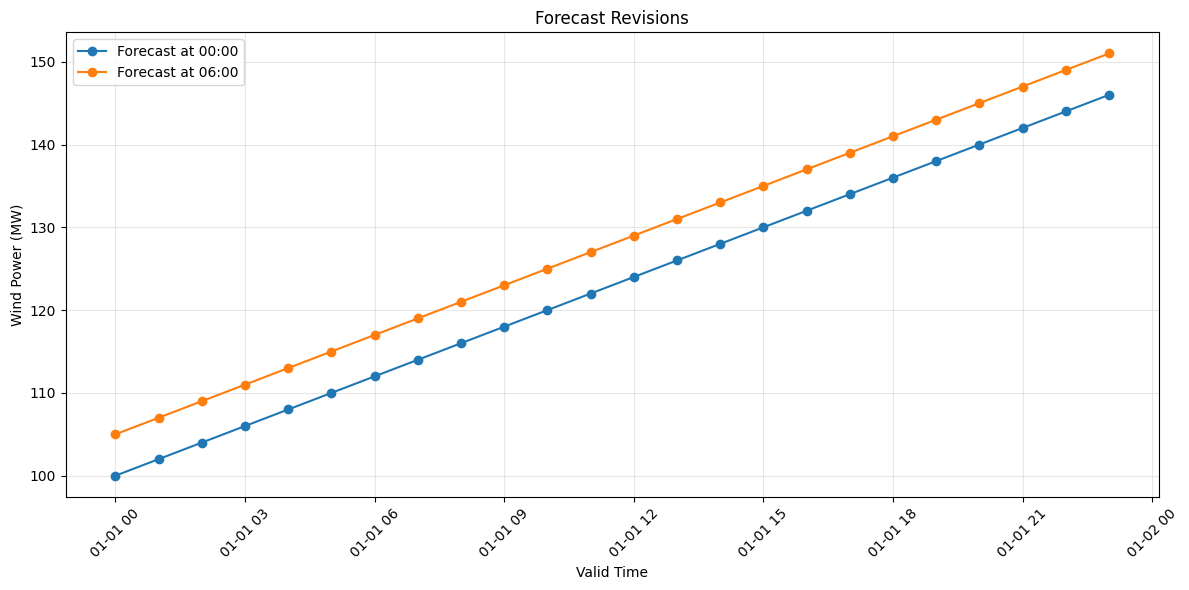

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

for known_time, data in df_all.groupby(level='known_time'):
    # Convert pint quantities to plain values for plotting
    values = data['wind_power'].pint.magnitude if hasattr(data['wind_power'], 'pint') else data['wind_power'].values
    plt.plot(data.index.get_level_values('valid_time'), values, marker='o', label=f'Forecast at {known_time.strftime("%H:%M")}')

plt.xlabel('Valid Time')
plt.ylabel('Wind Power (MW)')
plt.title('Forecast Revisions')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Summary

You've learned the basics of TimeDB:

1. **Create series** - Define your time series with name, unit, labels, and `data_class` (flat or overlapping)
2. **Insert data** - Store forecasts with `known_time` using `insert()`
3. **Read latest** - Get the most recent forecast for each time point using `read()`
4. **Read revisions** - Access all forecast versions using `read(versions=True)` to analyze changes

### Key Concepts

- **`valid_time`**: The time period being forecasted
- **`known_time`**: When the forecast was made
- **`data_class`**: `'flat'` for immutable facts (default), `'overlapping'` for versioned forecasts
- **Series Collection**: Use `.series().where()` to filter by name and labels
- **Forecast Revisions**: Multiple forecasts for the same `valid_time` with different `known_time`

### Next Steps

- Check out `nb_03_forecast_revisions.ipynb` for more detailed examples
- Explore other notebooks for advanced features